In [8]:
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from Datasets import RefinementDataset, GTADataset
from mmseg.models.backbones.mix_transformer import MixVisionTransformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import glob,os
from mmcv import Config
import cv2
import random
from Datasets import WeihToI3
from models import TransUNetLike
from scipy.ndimage import distance_transform_edt

In [34]:
def compute_sdf(mask: torch.Tensor) -> torch.Tensor:
    """
    Compute Signed Distance Field (SDF) from a binary mask using SciPy's distance transform.
    Negative values are inside the mask, positive outside.
    Each SDF is normalized to [-1, 1] by dividing by max(abs(sdf)).

    Args:
        mask (torch.Tensor): Binary tensor (0s and 1s). Shape (..., H, W)

    Returns:
        torch.Tensor: Normalized SDF tensor with same shape as input, dtype=torch.float32
    """
    device = mask.device
    original_shape = mask.shape
    mask_np = mask.detach().cpu().numpy()

    # Handle shape (H, W) or (B, H, W)
    squeeze_back = False
    if mask_np.ndim == 2:
        mask_np = mask_np[None, ...]
        squeeze_back = True

    sdf_list = []
    for m in mask_np:
        m_bool = m.astype(bool)
        outside = distance_transform_edt(~m_bool)
        inside = distance_transform_edt(m_bool)
        sdf = outside - inside  # Signed distance

        max_abs = np.max(np.abs(sdf))
        if max_abs > 0:
            sdf = sdf / max_abs  # Normalize to [-1, 1]
        else:
            sdf = np.zeros_like(sdf, dtype=np.float32)

        sdf_list.append(sdf.astype(np.float32))

    sdf_np = np.stack(sdf_list, axis=0)
    if squeeze_back:
        sdf_np = sdf_np[0]

    sdf_tensor = torch.from_numpy(sdf_np).to(device=device, dtype=torch.float32)
    return sdf_tensor.view(original_shape)

def extract_mix_redistribute_components(mask1: torch.Tensor, mask2: torch.Tensor, 
                                      shuffle: bool = True, 
                                      min_component_size: int = 10,
                                      return_sdf: bool = True):
    """
    Extract connected components from two masks, mix them, and redistribute into two new masks.
    Optimized version using OpenCV for maximum performance.
    
    Args:
        mask1 (torch.Tensor): First binary mask (any shape, will be squeezed to 2D)
        mask2 (torch.Tensor): Second binary mask (any shape, will be squeezed to 2D)
        shuffle (bool): Whether to randomly shuffle components before redistribution
        min_component_size (int): Minimum size for a component to be kept
        return_sdf (bool): Whether to return SDF maps instead of binary masks
    
    Returns:
        Tuple[torch.Tensor, torch.Tensor, Dict]: Two redistributed masks/SDFs (same shape as input) and metadata
    """
    # Handle tensor shapes - convert to numpy for processing
    original_device = mask1.device
    original_dtype = mask1.dtype
    original_shape1 = mask1.shape
    original_shape2 = mask2.shape
    
    if len(mask1.shape) > 2:
        mask1 = mask1.squeeze()
        mask2 = mask2.squeeze()
    
    # Convert to numpy for OpenCV processing
    mask1_np = mask1.cpu().numpy().astype(np.uint8)
    mask2_np = mask2.cpu().numpy().astype(np.uint8)
    H, W = mask1_np.shape
    
    # Calculate different regions for efficient component extraction
    mask1_only = mask1_np & (~mask2_np)
    mask2_only = mask2_np & (~mask1_np)
    intersection = mask1_np & mask2_np
    
    # Extract all components efficiently
    all_components = []
    component_metadata = []
    
    # Process each region separately for better performance
    regions = [
        (mask1_only, 'mask1_only'),
        (mask2_only, 'mask2_only'), 
        (intersection, 'intersection')
    ]
    
    for region_mask, source_name in regions:
        if region_mask.sum() > 0:  # Only process if region has pixels
            # OpenCV connected components - fastest method
            num_labels, labels = cv2.connectedComponents(region_mask, connectivity=4)
            
            # Extract each component (skip label 0 which is background)
            for label_id in range(1, num_labels):
                component_mask = (labels == label_id).astype(np.uint8)
                component_size = np.sum(component_mask)
                
                # Filter out small components
                if component_size >= min_component_size:
                    all_components.append(component_mask)
                    component_metadata.append({
                        'source': source_name,
                        'size': component_size,
                        'original_label': label_id
                    })
    
    # Handle edge case: no components found
    if len(all_components) == 0:
        if return_sdf:
            # Return SDF of empty masks (all positive values)
            empty_sdf = np.ones((H, W), dtype=np.float32) * np.sqrt(H*H + W*W)
            empty_tensor = torch.from_numpy(empty_sdf).to(original_device).float()
            if len(original_shape1) != len(empty_tensor.shape):
                empty_tensor = empty_tensor.view(original_shape1)
            return empty_tensor, empty_tensor
        else:
            empty_mask = torch.zeros_like(mask1)
            return empty_mask, empty_mask,
    # Shuffle components if requested
    if shuffle:
        combined_data = list(zip(all_components, component_metadata))
        random.shuffle(combined_data)
        all_components, component_metadata = zip(*combined_data)
        all_components = list(all_components)
        component_metadata = list(component_metadata)
    
    # Redistribute components into two masks
    # Strategy: alternate assignment or use more sophisticated distribution
    new_mask1 = np.zeros((H, W), dtype=np.uint8)
    new_mask2 = np.zeros((H, W), dtype=np.uint8)
    
    redistribution_info = []
    
    # Alternate assignment for balanced distribution
    for i, (component, metadata) in enumerate(zip(all_components, component_metadata)):
        if i % 2 == 0:
            new_mask1 |= component
            assigned_to = 'mask1'
        else:
            new_mask2 |= component
            assigned_to = 'mask2'
        
        redistribution_info.append({
            'component_id': i,
            'assigned_to': assigned_to,
            'original_source': metadata['source'],
            'size': metadata['size']
        })
    
    # Convert to SDF if requested, otherwise keep as binary masks
    if return_sdf:
        
        result_mask1 = torch.from_numpy(new_mask1).to(original_device).to(original_dtype)
        result_mask2 = torch.from_numpy(new_mask2).to(original_device).to(original_dtype)
        
        # Convert to torch tensors
        result_mask1 = compute_sdf(result_mask1)
        result_mask2 = compute_sdf(result_mask2)
    else:
        # Convert back to torch tensors with original dtype
        result_mask1 = torch.from_numpy(new_mask1).to(original_device).to(original_dtype)
        result_mask2 = torch.from_numpy(new_mask2).to(original_device).to(original_dtype)
    
    # Restore original shape if it was different (e.g., (1, H, W) -> (H, W) -> (1, H, W))
    if len(original_shape1) != len(result_mask1.shape):
        result_mask1 = result_mask1.view(original_shape1)
        result_mask2 = result_mask2.view(original_shape2)
    
    return result_mask1, result_mask2

In [35]:
train_ds = WeihToI3(mode="train")
val_ds = WeihToI3(mode="val")

In [36]:
pl_image, sam_image, gt_image = train_ds[600]

In [37]:
result_mask1, result_mask2 = extract_mix_redistribute_components(pl_image, sam_image)

In [40]:
result_mask1.max()

tensor(1.)

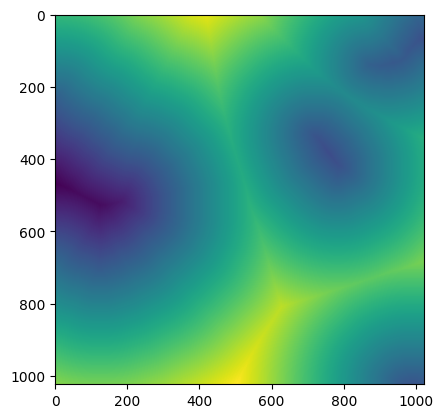

In [41]:
plt.imshow(compute_sdf(pl_image.squeeze()))

(-0.5, 1023.5, 1023.5, -0.5)

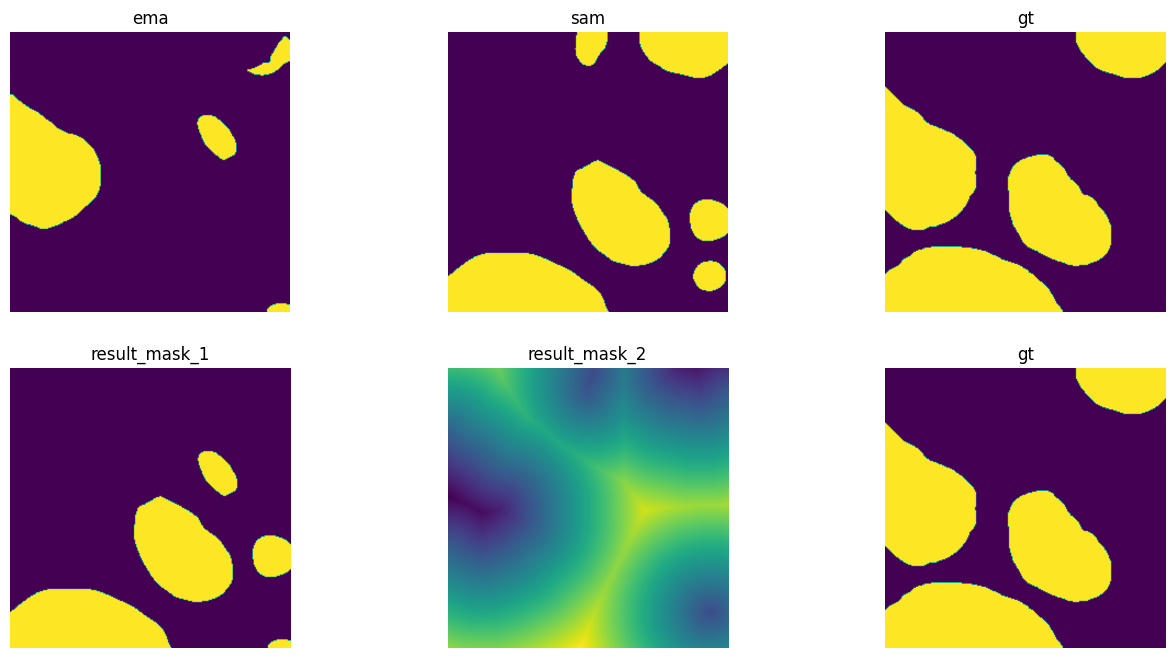

In [31]:
fig,axes = plt.subplots(2,3,figsize=(16,8))
axes = axes.flatten()
axes[0].imshow(pl_image.squeeze())
axes[0].set_title("ema")
axes[0].axis("off")
axes[1].imshow(sam_image.squeeze())
axes[1].set_title("sam")
axes[1].axis("off")
axes[2].imshow(gt_image.squeeze())
axes[2].set_title("gt")
axes[2].axis("off")
axes[3].imshow((result_mask1.squeeze()<=0).int())
axes[3].set_title("result_mask_1")
axes[3].axis("off")
axes[4].imshow(result_mask2.squeeze())
axes[4].set_title("result_mask_2")
axes[4].axis("off")
axes[5].imshow(gt_image.squeeze())
axes[5].set_title("gt")
axes[5].axis("off")
